# Toll Bridge Task

## Expoloratory Data Analysis

In [224]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import urllib
import requests
import json

In [225]:
df = pd.read_json(r"logins.json")
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### Observing Data from A Time Series Perspective

Let's Visualize the entire data

<AxesSubplot:>

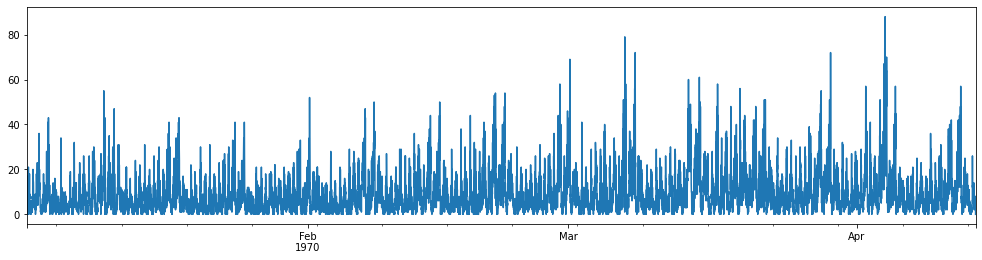

In [226]:
#using a timedelta of 15 min, count how many logins fall in that time period. 
#Create new series of counts versus periods.
rng = pd.date_range('1970-01-01 20:00:00', '1970-04-13 19:00:00', freq='15T')
ts = pd.Series(np.zeros(len(rng)), index=rng)

log_df =df.copy(deep=True)
p = 0 
for i in range(len(log_df)):
    s = ts.index[p] #start time
    e = ts.index[p+1] #end time
    t = log_df['login_time'][i]
    if s < t < e:
        ts[p] = ts[p] + 1
    else:
        while (e < t): #increment to the next time 
            p = p + 1 
            s = ts.index[p] #change start time
            e = ts.index[p+1] # change end time
        ts[p] = ts[p] + 1
        
plt.figure(figsize=(17,4)) # The entire data set
ts.plot()

There appears to a be a cycle to the peaks and valleys (they follow a weekly basis as there are 4 peaks each month). Considering there are usually four weeks in a month this suggests this might follow a day of the week pattern. Next we check to see what the data looks like on a week basis.

<AxesSubplot:>

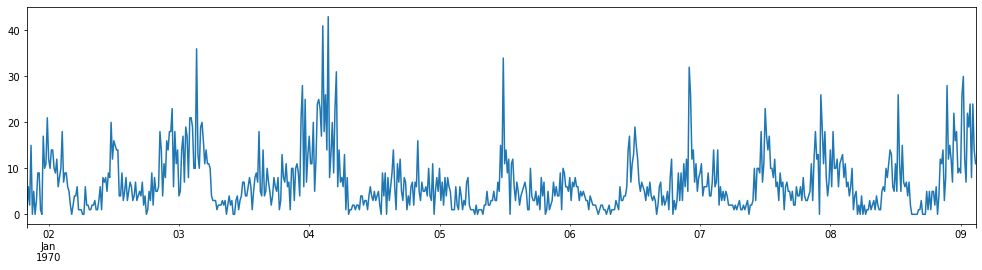

In [227]:
plt.figure(figsize=(17,4))
ts[0:700].plot() # 1st week plot

<AxesSubplot:>

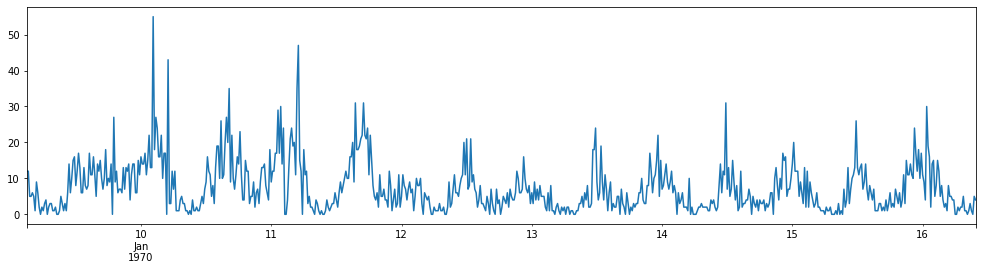

In [228]:
plt.figure(figsize=(17,4))
ts[700:1400].plot() # 2nd Week

From the above two graphs we see there is a ppears to be a max point every 12 hours. If we countinue this for the next 8 weeks this pattern will hold true. This suggests there is a a twice daily cycle with regards to logins. Lets see if we can see this out in the data.

### Looking at Logins from a Resampled 15 Minute Bin Perspective

In [229]:
#resampling df to 15-minute intervals
df_logins = df.resample("15min", on="login_time").count()

#cleaning up df
df_logins.index.name = "idx"
df_logins.reset_index(inplace=True)
df_logins.rename({"login_time":"logins"}, axis=1, inplace=True)

#extracting hours and days
df_logins["hour"] = df_logins["idx"].dt.hour
df_logins["day"] = df_logins["idx"].dt.day_name()

#giving AM/PM labels
day_or_night = lambda row: "AM" if row in range(0,12) else "PM"
df_logins["AM-PM"] = df_logins["hour"].apply(day_or_night)

display(df_logins.head())

,idx,logins,hour,day,AM-PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


### Checking Hypothoses 1 - There is a clear weekly cycle

Is there peak day/two days every week. Does the week show a pettern?

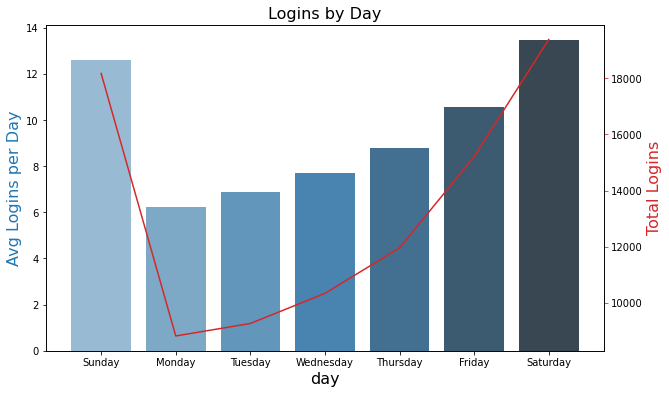

In [230]:
#Sum logins per day of week
df_day = df_logins.groupby("day").sum()[["logins"]]

#Average logins per day of week
df_day["daily_avg"] = df_logins.groupby("day").mean()[["logins"]]
sorter = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(sorter,range(len(sorter))))
sorterIndex
df_day = df_day.reset_index()
df_day['day1'] = df_day['day'].map(sorterIndex)
df_day.sort_values('day1', inplace=True)
df_day=df_day.set_index('day1')


#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
#bar plot creation
ax1.set_title('Logins by Day', fontsize=16)
ax1.set_xlabel('Day', fontsize=16)
ax1 = sns.barplot(x='day', y='daily_avg', data = df_day, palette="Blues_d")
ax1.tick_params(axis='y')
ax1.set_ylabel('Avg Logins per Day', fontsize=16, color=color)
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Total Logins', fontsize=16, color=color)
ax2 = sns.lineplot(x='day', y='logins', data = df_day, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

From the above graph we see that logins happen much more fequently on the weekend (sunday/saturday) and then sharply decrease at the beginning of the work week (Monday, Tuesday). So yes there is a weekly Cycle

### Hypothosis 2- There are two max times ever day approximately every 12 hours.

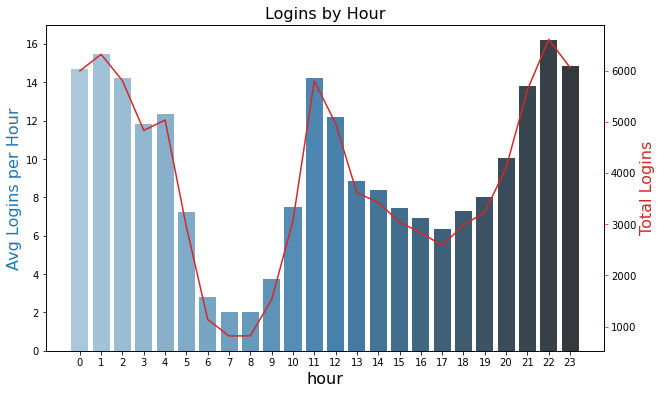

In [231]:
#Sum logins per hour
df_hour = df_logins.groupby("hour").sum()[["logins"]]

#Average hourly logins per hour
df_hour["hourly_avg"] = df_logins.groupby("hour").mean()[["logins"]]

df_hour= df_hour.reset_index()
#Create combo chart
fig, ax1 = plt.subplots(figsize=(10,6))
color = 'tab:blue'
#bar plot creation
ax1.set_title('Logins by Hour', fontsize=16)
ax1.set_xlabel('Hour', fontsize=16)
ax1 = sns.barplot(x='hour', y='hourly_avg', data = df_hour, palette="Blues_d")
ax1.set_ylabel('Avg Logins per Hour', fontsize=16, color=color)
ax1.tick_params(axis='y')
#specify we want to share the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
#line plot creation
ax2.set_ylabel('Total Logins', fontsize=16, color=color)
ax2 = sns.lineplot(x='hour', y='logins', data = df_hour, sort=False, color=color)
ax2.tick_params(axis='y', color=color)
#show plot
plt.show()

From the above graph we see that there are two peak peajs at the begining of the day and mid day. Now the problem here is that we already seen that the weekend days act differently than the rest of the week let's see therefore if the hours max and min also change by the day.

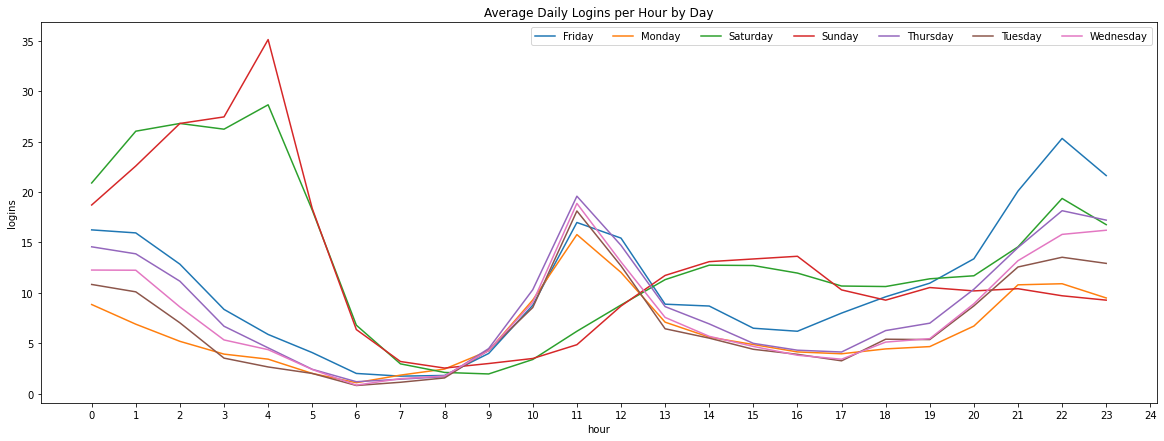

In [232]:
#getting average daily logins per hour
df_total = df_logins.groupby(["hour", "day"]).mean().reset_index()

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="logins", data=df_total, hue="day")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour by Day")
plt.xticks(range(0,25))

#display plot
plt.show()

From the above graph we can see that Sunday and Saturday have peak times very different than the weekend. They have one peak at around 3 to 5 am. While on the flip side we can see that weekday has two max points one at 12 and the other early in the day.

## Answer to Part 2- Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way  toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

#### 1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

We are checking to see if drive partnering (aka ride sharing) would increase on the route between the cities if tolls are reimbursed. First we  need to find out why the cities of Gotham and Metropolis want to promote ride sharing aka increasing buisnessdecreasing pollution.  

If it to decrease pollution the key performance indicator (KPI) is ideally the amount of pollution driven by cars, the next best KPI is conversion rate of people from driving alone to ride sharing  when going between the two cities. If neither information is not easily avaialable the KPI is the percentage of people who are ride sharing.

If it is to increase ridge sharing business then the KPI is ideally the profit made by ride sharing companies on the bridge. If that information is not easily avaialable the KPI is the revenue of ride sharing between the citires

#### 2)Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a) how you will implement the experiment
b) what statistical test(s) you will conduct to verify the significance of the observation
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

Easiest part to answer is the statistical test. This would be a two sample t-test with the use of the above KPI.

The hardest part is of course designing the experiment particularly trying to create a random sample where the only change was the toll on the bridge. This is especially dependent on whether the city wants to decrease pollution or increase business.

A key detail I would  useis to find another nearby city with a similar demographic/ride sharing in the are a that is not effected by the booth (Blüdhaven?) and see if I could get information from that city as well both before and after the toll both is put in. This allows us to have a constant group to compare of the effect of the toll booth.


Let's start with the scenario where the cities want to promote the ride sharing business. Best case scenario we ask one of the larger ride sharing companies to just give us the revenue information of their number of drivers before and after the toll booth reimbursal comes in. This should be for two areas Gotham and Metropolis Area as well as Bludhaven. Then we do a panel data study comparing the revenue made by the ride sharing companies before and after in Gotham, Metropolis and Bludhaven. The hypothis becomes the likelhood that the difference in the before and after samples for the two areas are the same. If there is a statistically signicant larger revenue increase for the Gotham/ Metropolis area.

Caveats: If bludhaven does anything to promote ride sharing/ driving differently than metropolis or Gotham that is an outstanding effect. This is unlikely though.


## Answer Part 3

In [266]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

#save file to memory
file = open("ultimate_data_challenge.json", "r")
dataset = file.read()
file.close()

#load file as JSON
data = json.loads(dataset)

#create df from JSON dataset
df = pd.DataFrame(data)

#parse dates
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])
df["signup_date"] = pd.to_datetime(df["signup_date"])

#A user is considered active when a user takes at least one trip during its first 30 days.
active = lambda row: 1 if row != 0 else 0
df["active"] = df["trips_in_first_30_days"].apply(active)


df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1


The below sequence runs through the dataframe, and says if the last trip date is 30 days times 5 months 
greater than the start date then it is an active user (1) in its 6 month. Else it is not and gets a 0 flag
creates a date six months from the start date, and then checks if the last trip falls


In [267]:
from datetime import timedelta

sixth_month_active = lambda row: 1 if row["last_trip_date"] - row["signup_date"] > timedelta(days=30*5) else 0

df["sixth_month_active"] = df.apply(sixth_month_active, axis=1)

df[["signup_date", "last_trip_date", "sixth_month_active"]].head()


,signup_date,last_trip_date,sixth_month_active
0,2014-01-25,2014-06-17,0
1,2014-01-29,2014-05-05,0
2,2014-01-06,2014-01-07,0
3,2014-01-10,2014-06-29,1
4,2014-01-27,2014-03-15,0


In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
 12  active                  50000 non-null  int64 

### How much of the data is kept

The are three features with nulls in then phone, avg_rating_of_driver, and avg_rating_by_driver. As phone is a categorical variable I can easily add another category "Unknown" to describe the nulls. This neither adds or changes information in the data set.

So there remains two variables we have two decide if we should either impute values or eliminate. If these rows with nulls values have the same proprtion of active/inactive as the larger data set might be able to use the mean value of the column into the null values. However looking below we realize that if there is a null value the user is less likely to be active. That means I can't use mean as an imputer because the variable does not act like a null value.

My next option  is 0 when looking at relationship between average rating by driver and retention rate we realize three things. 
1) Ratings by driver do not go down to 0 tso this number is out of range. 
2) Ratings by driver skew right
3) There is a negative relationship between driver rating and retention rate. Therefore if 0 was put in it should imply more active users
All of the above means we cann not impute on 0. 

There is also no clear aproximation of these missing values that would make this an easy knn imputation, iterative imputation a clear answer. 

So we are left with eliminating those rows or eliminating that column. At the end of the day I retain 83.8% of my data. 


In [269]:
#Fill String Variable with Category other- we neither lose nor gain information this way
df.phone= df.phone.fillna('Unknown')


In [270]:
print('six month active count')
print(df['sixth_month_active'].value_counts())
print('If null value in row six month active count')
print(df[df['avg_rating_of_driver'].isna() |df['avg_rating_by_driver'].isna() ]['sixth_month_active'].value_counts())

six month active count
0    37802
1    12198
Name: sixth_month_active, dtype: int64
If null value in row six month active count
0    7373
1     883
Name: sixth_month_active, dtype: int64


In [271]:
### U

<AxesSubplot:xlabel='avg_rating_by_driver', ylabel='sixth_month_active'>

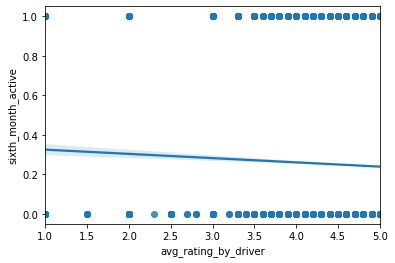

In [272]:
sns.regplot(y=df['sixth_month_active'], x=df['avg_rating_by_driver'], fit_reg = True)

In [273]:
df_old = df.copy(deep=True)
df=df.dropna()

In [274]:
df['sixth_month_active'].count()/df_old['sixth_month_active'].count()

0.83488

### EDA relationships

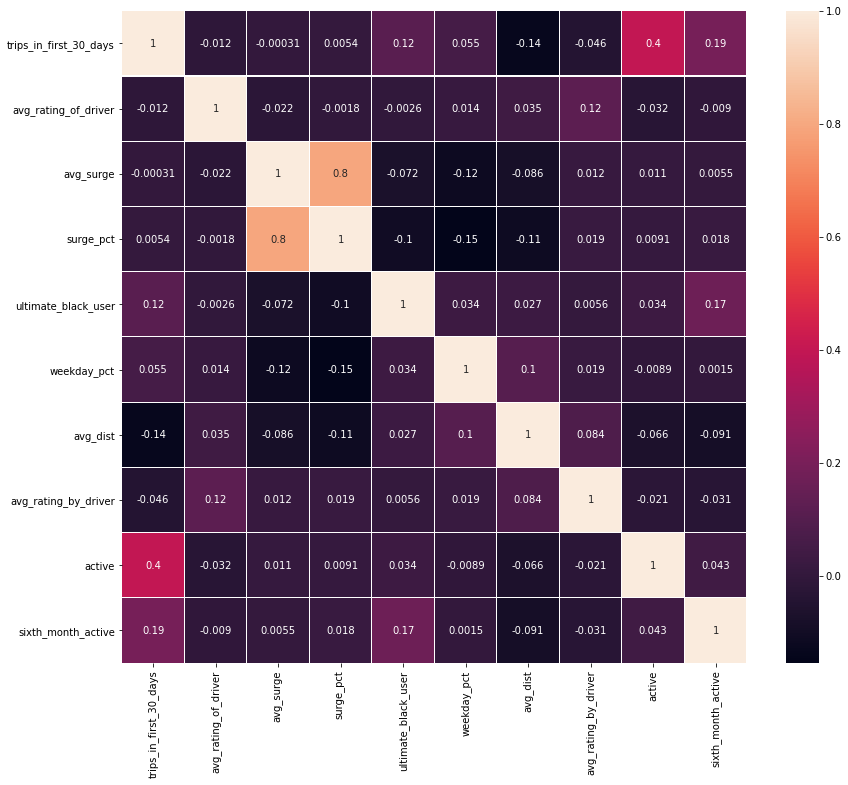

In [275]:
#continuous correlaton 
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1, annot=True)
plt.yticks(rotation=0);
plt.savefig('correlation',bbox_inches='tight')

We first note that surge_pct and avg_surge are closesly correlated. We might not want to include both.

Looking at target feature we can see  a strong relationship between six month active and trips in first thirty days. However not all relationnships are linear let's check the relationship for a few of the other featyres

<AxesSubplot:xlabel='avg_rating_by_driver', ylabel='sixth_month_active'>

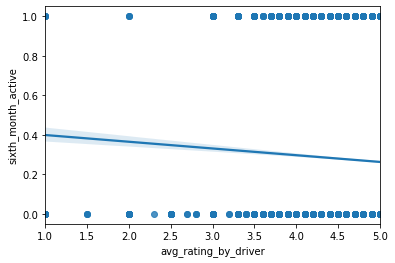

In [276]:
sns.regplot(y=df['sixth_month_active'], x=df['avg_rating_by_driver'], fit_reg = True)

<AxesSubplot:xlabel='avg_rating_of_driver', ylabel='sixth_month_active'>

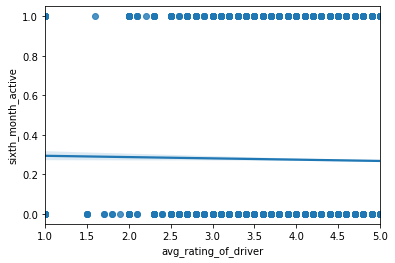

In [277]:
sns.regplot(y=df['sixth_month_active'], x=df['avg_rating_of_driver'], fit_reg = True)

At first glance wrak relationship for six month active and active_surge. Avg_surge also skews low

<AxesSubplot:xlabel='avg_surge', ylabel='sixth_month_active'>

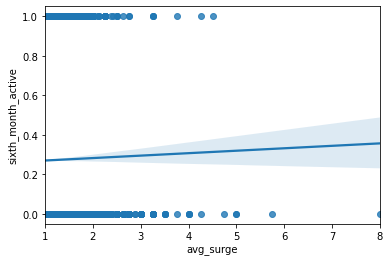

In [278]:
sns.regplot(y=df['sixth_month_active'], x=df['avg_surge'], fit_reg = True)

There is a small relationship for surge pct however it is could be sigifivant

<AxesSubplot:xlabel='surge_pct', ylabel='sixth_month_active'>

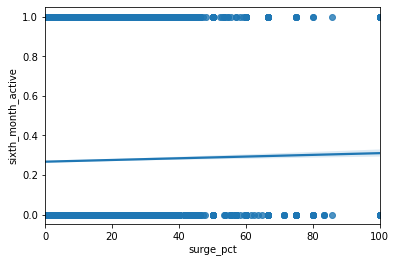

In [279]:
sns.regplot(y=df['sixth_month_active'], x=df['surge_pct'], fit_reg = True)

There is very weak relationship for weekday pct

<AxesSubplot:xlabel='weekday_pct', ylabel='sixth_month_active'>

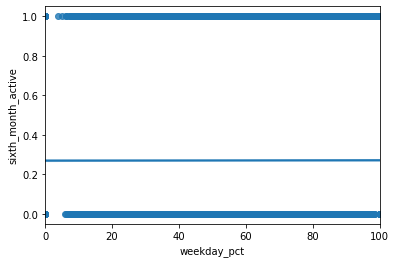

In [280]:
sns.regplot(y=df['sixth_month_active'], x=df['weekday_pct'], fit_reg = True)

<AxesSubplot:xlabel='avg_dist', ylabel='sixth_month_active'>

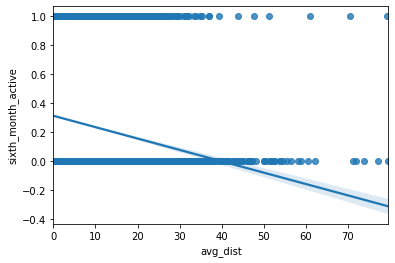

In [281]:
sns.regplot(y=df['sixth_month_active'], x=df['avg_dist'], fit_reg = True)

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41744 entries, 0 to 49998
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41744 non-null  object        
 1   trips_in_first_30_days  41744 non-null  int64         
 2   signup_date             41744 non-null  datetime64[ns]
 3   avg_rating_of_driver    41744 non-null  float64       
 4   avg_surge               41744 non-null  float64       
 5   last_trip_date          41744 non-null  datetime64[ns]
 6   phone                   41744 non-null  object        
 7   surge_pct               41744 non-null  float64       
 8   ultimate_black_user     41744 non-null  bool          
 9   weekday_pct             41744 non-null  float64       
 10  avg_dist                41744 non-null  float64       
 11  avg_rating_by_driver    41744 non-null  float64       
 12  active                  41744 non-null  int64 

### Random Forest Classifier Machine Learning

In [283]:
#feature_manipulation
df.signup_date.describe()
df['signup_day']= pd.DatetimeIndex(df['signup_date']).day
df['signup_weekday']= pd.DatetimeIndex(df['signup_date']).dayofweek
#didn't use last trip date extraction as the combo of the two will give you six month active

In [284]:
#preprocessing
df["ultimate_black_user"] = df["ultimate_black_user"].map({False:0, True:1}).astype("category")
df["active"] = df["active"].astype("category")




In [285]:
#Split Data
y = df['sixth_month_active']

#object id gives no useful info and both name and email are pretty unique to each user
#(we tried to only take data after the @ in emails and got too many categories

X = df.drop(['sixth_month_active','signup_date','last_trip_date'],axis = 1)

seed = 28  # so that the result is reproducible and the meaning of life (31)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = seed)

In [286]:
#Encode categorical variables

#seperate categorical features
features_to_encode = X_train.columns[(X_train.dtypes==object) | (X_train.dtypes=='category')].tolist()

#encode categorical feathres
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

col_trans = make_column_transformer(
    (OneHotEncoder(),features_to_encode),remainder = "passthrough")

#Since we are using random forest numeric scaling is not useful here
#Truly if not usking sklearn random forest which is a binary tree random forest could also have let not 
#need to get rid of nulls but in the interest of time. 

In [287]:
#Classifier algorithms

In [288]:
#create random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      oob_score=True,
                      random_state=seed,
                      max_features='auto', n_estimators= 150   
)

#train model
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(col_trans, rf_classifier)
pipe = Pipeline([
    ('col_trans', col_trans),
    ('rf', rf_classifier)])

#grid search parameters
params = {"rf__max_depth" : [10, 15, 20],
         'rf__min_samples_leaf': [10, 15, 20],
          'rf__min_samples_split': [2, 5, 10]
         }            
            
#fitting the pipeline to the grid search
cv = GridSearchCV(pipe, param_grid=params, cv=3)
cv.fit(X_train, y_train)

print(cv)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['city',
                                                                          'phone',
                                                                          'ultimate_black_user',
                                                                          'active'])])),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=150,
                                                               oob_score=True,
                                                               random_state=28))]),
             param_grid=

Now we identify best model

In [289]:
print(f"Best parameters: {cv.best_params_}")
print(f"Training accuracy score from tuned model: \
       {cv.best_score_*100:.1f}%")
#predict

pipe_rf = cv.best_estimator_
y_pred = pipe_rf.predict(X_test)

Best parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 15, 'rf__min_samples_split': 2}
Training accuracy score from tuned model:        80.7%


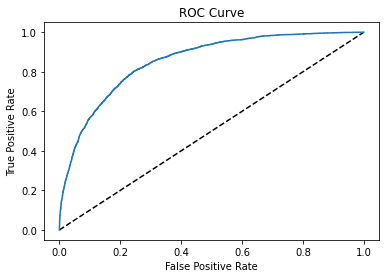

In [290]:
from sklearn.metrics import roc_curve

# Compute predicted probabilities: y_pred_prob
y_pred_prob = pipe_rf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()



In [291]:
#The below function comes from user DTrimarchi10. I l just like using it as I think it createst the best confusion matrix.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        

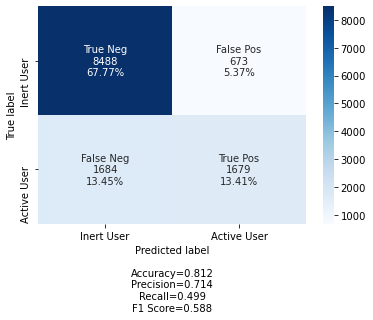

In [292]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score


labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Inert User', 'Active User']
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')
plt.savefig("Confusion Matrix")

## Feature Importance Random Forest Regression

### Create Feature Importance Tables

In [293]:
ohe = pipe_rf.named_steps['col_trans'].named_transformers_['onehotencoder']
#cc= pipe.named_steps['col_trans'].transformers[-1][-1]
cc= X_train.select_dtypes(['object', 'category']).columns
cat_cols= ohe.get_feature_names(input_features=cc)
numerical_cols = X_train.select_dtypes([np.int64,np.float64]).columns
feature_names = np.r_[numerical_cols,cat_cols]
fimpotance_train = pd.DataFrame(pipe_rf.named_steps['rf'].feature_importances_, columns=['Mean Feature Importance'], index=feature_names)
fimpotance_train

,Mean Feature Importance
trips_in_first_30_days,0.022253
avg_rating_of_driver,0.050687
avg_surge,0.011118
surge_pct,0.034379
weekday_pct,0.000030
avg_dist,0.026111
avg_rating_by_driver,0.021847
signup_day,0.024807
signup_weekday,0.005580
city_Astapor,0.006254


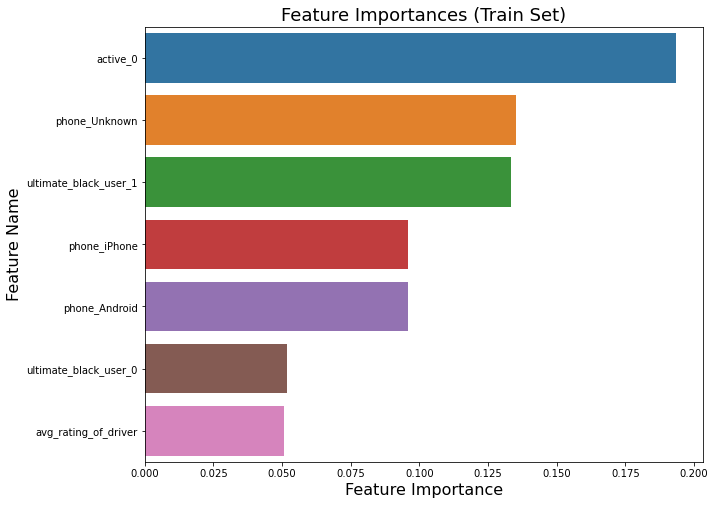

In [294]:
z30 = fimpotance_train.sort_values(by= ['Mean Feature Importance'], ascending= False)
z30=z30.reset_index().rename(columns={"index": "Feature Name"})
z5= z30.sort_values(by= ['Mean Feature Importance'], ascending= False).head(7)
z20= z30.sort_values(by= ['Mean Feature Importance'], ascending= False).tail(15)
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='Mean Feature Importance',  y="Feature Name",  data=z5)
plt.title("Feature Importances (Train Set)", fontsize=18)
plt.xlabel('Feature Importance', fontsize=16)
plt.ylabel('Feature Name', fontsize=16)
#plt.yticks(fontsize=14)
plt.savefig("Category Feature Importance")

In [295]:
from sklearn.inspection import permutation_importance
#Calculate feature importance for five splits using the train set
result_train = permutation_importance(pipe_rf, X_train, y_train, n_repeats=3, n_jobs=-1, random_state=seed)

#Create data frame of feature importances for the five folds given the train set
feature_names2= X_train.columns
fimpotance_train2 = pd.DataFrame(result_train.importances.T, columns=feature_names2)
fimpotance_train2

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_day,signup_weekday
0,0.030972,0.006263,0.010301,0.015264,0.023511,0.020260,0.019713,0.022108,0.009822,0.027584,0.003867,0.056982,0.004586
1,0.030424,0.006742,0.011294,0.013347,0.023272,0.019747,0.018652,0.022108,0.009309,0.027789,0.003936,0.060301,0.004517
2,0.030219,0.006571,0.010164,0.014339,0.022313,0.020363,0.019713,0.021047,0.009822,0.027789,0.003833,0.059309,0.004586


In [296]:
#Create data frame of feature importances for the five folds given the train set
feature_names2= X_train.columns
fimpotance_train2 = pd.DataFrame(result_train.importances.T, columns=feature_names2)
fimpotance_train2

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_day,signup_weekday
0,0.030972,0.006263,0.010301,0.015264,0.023511,0.020260,0.019713,0.022108,0.009822,0.027584,0.003867,0.056982,0.004586
1,0.030424,0.006742,0.011294,0.013347,0.023272,0.019747,0.018652,0.022108,0.009309,0.027789,0.003936,0.060301,0.004517
2,0.030219,0.006571,0.010164,0.014339,0.022313,0.020363,0.019713,0.021047,0.009822,0.027789,0.003833,0.059309,0.004586


In [297]:
from sklearn.inspection import permutation_importance
#Calculate feature importance for five splits using the test set
result_test = permutation_importance(pipe_rf, X_test, y_test, n_repeats=5, n_jobs=-1, random_state=seed)

#Create data frame of feature importances for the five folds given the train set
fimpotance_test2 = pd.DataFrame(result_test.importances.T, columns=feature_names2)
fimpotance_test2

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active,signup_day,signup_weekday
0,0.016289,-0.000319,0.002555,0.003833,0.012935,0.008224,0.014213,0.013973,0.003194,0.018604,0.002316,0.043277,0.000639
1,0.014133,0.001357,0.000878,0.005190,0.014372,0.008544,0.011578,0.012296,-0.000240,0.015011,0.002635,0.046231,0.000479
2,0.014133,0.000958,0.002076,0.007905,0.013175,0.010061,0.010300,0.015889,0.002236,0.018125,0.002715,0.043596,0.000798
3,0.017327,-0.000080,0.003912,0.008783,0.013494,0.010141,0.011019,0.011817,0.003833,0.014372,0.002715,0.045433,0.000080
4,0.015171,0.001198,0.003753,0.005509,0.012296,0.011019,0.007825,0.014612,0.004392,0.016768,0.001198,0.046471,0.000479


### Leverage the Insights gained from the model to


Below we see that the most important features are sign up date, average rating by driver, city and weekday percentage. This is stable not just in the training data but also the test data. 

**Customer Behavior:**
The users most likely to be retrained signed up for their account early. This makes sense as these customers might need to have transportation so they could not afford a delay. Further said users are more likely to use their passes on the weekday.

From this I would suggst Ultimate target their advertisting at the beginning of the month.




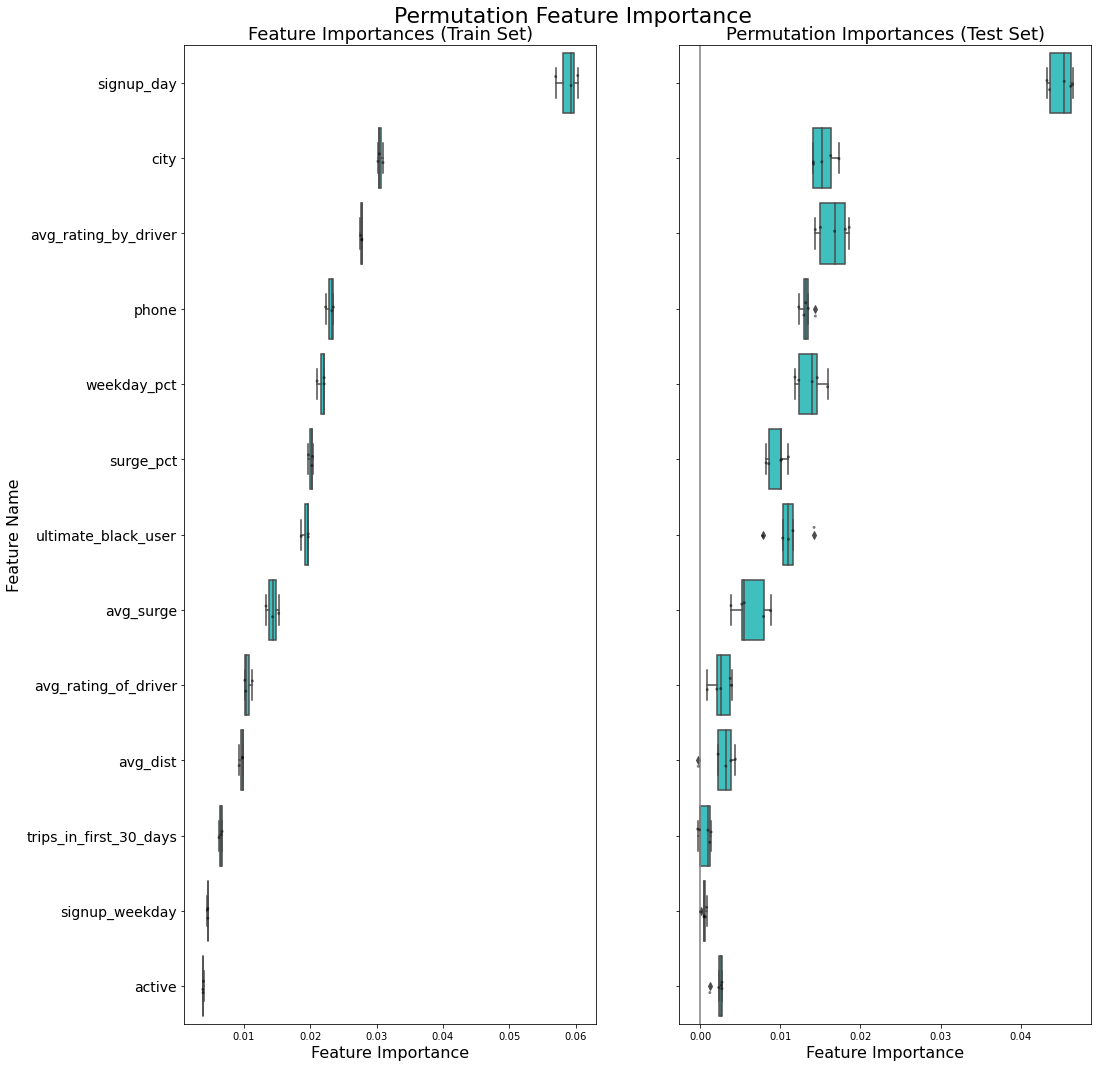

In [298]:
fimpotance_train2= fimpotance_train2.reindex(fimpotance_train2.mean().sort_values(ascending=False).index, axis=1)
fimpotance_test2= fimpotance_test2.reindex(fimpotance_train2.mean().sort_values(ascending=False).index, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(18, 18), sharey=True, sharex=True)
fig.suptitle('Permutation Feature Importance', fontsize=22, y=0.91, x= 0.5)
ax = plt.subplot(121)
sns.stripplot(data=fimpotance_train2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_train2, orient='h', color='cyan', saturation=0.5)
plt.title("Feature Importances (Train Set)", fontsize=18)
plt.xlabel('Feature Importance', fontsize=16)
plt.ylabel('Feature Name', fontsize=16)
plt.yticks(fontsize=14)

plt.subplot(122)



#graphing coefficent and importance
#sns.swarmplot(data=coefs2, orient='h', color='k', alpha=0.5, size=3)
sns.stripplot(data=fimpotance_test2, orient='h', color='k', alpha=0.5, size=3)
sns.boxplot(data=fimpotance_test2, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.title("Permutation Importances (Test Set)", fontsize=18)
plt.xlabel('Feature Importance', fontsize=16)
plt.subplots_adjust(left=.2)

for ax in fig.get_axes():
    ax.label_outer()
